In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.utils as vutils

In [2]:
# --- Configuration ---
device = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 1e-4
BATCH_SIZE = 64
IMAGE_SIZE = 64
CHANNELS_IMG = 1
Z_DIM = 100
NUM_EPOCHS = 30  # Increased for better convergence
FEATURES_CRITIC = 64
FEATURES_GEN = 64
CRITIC_ITERATIONS = 5
LAMBDA_GP = 10  # Standard weight for Gradient Penalty

In [3]:

# --- 1. The Critic (Modified for GP) ---
class Critic(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Critic, self).__init__()
        self.critic = nn.Sequential(
            nn.Conv2d(channels_img, features_d, 4, 2, 1),
            nn.LeakyReLU(0.2),
            # Note: We use InstanceNorm/LayerNorm instead of BatchNorm for WGAN-GP
            self._block(features_d, features_d * 2, 4, 2, 1),
            self._block(features_d * 2, features_d * 4, 4, 2, 1),
            self._block(features_d * 4, features_d * 8, 4, 2, 1),
            nn.Conv2d(features_d * 8, 1, 4, 2, 0),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.InstanceNorm2d(out_channels, affine=True), # Better for GP
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.critic(x)

# --- 2. The Generator (Same structure, SiLU/ReLU fine-tuning) ---
class Generator(nn.Module):
    def __init__(self, z_dim, channels_img, features_g):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            self._block(z_dim, features_g * 16, 4, 1, 0),
            self._block(features_g * 16, features_g * 8, 4, 2, 1),
            self._block(features_g * 8, features_g * 4, 4, 2, 1),
            self._block(features_g * 4, features_g * 2, 4, 2, 1),
            nn.ConvTranspose2d(features_g * 2, channels_img, 4, 2, 1),
            nn.Tanh(),
        )

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.gen(x)

# --- 3. Gradient Penalty Function ---
def gradient_penalty(critic, real, fake, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    alpha = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * alpha + fake * (1 - alpha)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty


Epoch [0/30] Batch 0/938 Loss C: -13.1135 Loss G: 5.6344
Epoch [0/30] Batch 100/938 Loss C: -68.6390 Loss G: 53.7382
Epoch [0/30] Batch 200/938 Loss C: -70.9390 Loss G: 65.3036
Epoch [0/30] Batch 300/938 Loss C: -71.4133 Loss G: 69.2230
Epoch [0/30] Batch 400/938 Loss C: -59.5122 Loss G: 61.8224
Epoch [0/30] Batch 500/938 Loss C: -51.6916 Loss G: 47.5632
Epoch [0/30] Batch 600/938 Loss C: -28.5371 Loss G: 36.3417
Epoch [0/30] Batch 700/938 Loss C: -7.4841 Loss G: 32.0489
Epoch [0/30] Batch 800/938 Loss C: -10.4127 Loss G: 41.5192
Epoch [0/30] Batch 900/938 Loss C: -12.0007 Loss G: 25.8330
Epoch [1/30] Batch 0/938 Loss C: -11.6246 Loss G: 33.5254
Epoch [1/30] Batch 100/938 Loss C: -12.3270 Loss G: 29.1539
Epoch [1/30] Batch 200/938 Loss C: -9.1504 Loss G: 33.4676
Epoch [1/30] Batch 300/938 Loss C: -10.7363 Loss G: 35.3801
Epoch [1/30] Batch 400/938 Loss C: -10.3200 Loss G: 33.6130
Epoch [1/30] Batch 500/938 Loss C: -10.5535 Loss G: 35.1843
Epoch [1/30] Batch 600/938 Loss C: -9.2406 Loss

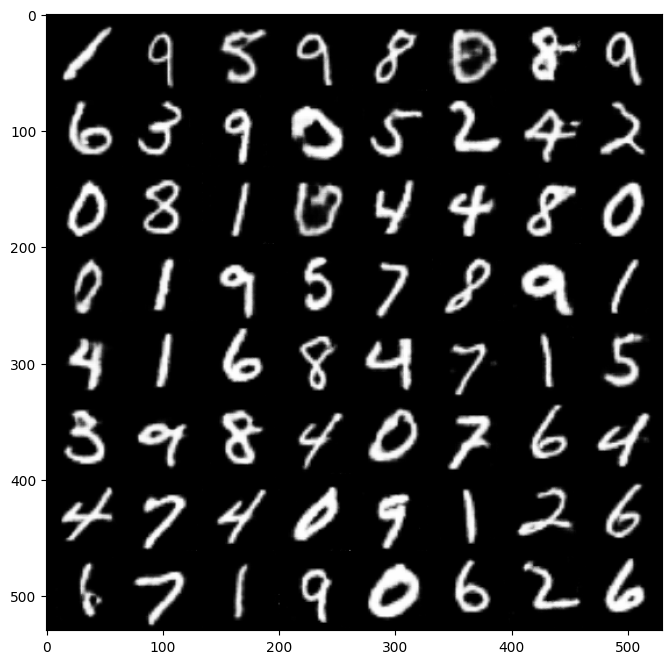

In [4]:
# --- 4. Initialization & Setup ---
dataset = torchvision.datasets.MNIST(root="dataset/", transform=transforms.Compose([
    transforms.Resize(IMAGE_SIZE), transforms.ToTensor(), transforms.Normalize([0.5], [0.5]),
]), download=True)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
critic = Critic(CHANNELS_IMG, FEATURES_CRITIC).to(device)
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))
opt_critic = optim.Adam(critic.parameters(), lr=LEARNING_RATE, betas=(0.0, 0.9))

# --- 5. Training Loop ---
for epoch in range(NUM_EPOCHS):
    for batch_idx, (real, _) in enumerate(loader):
        real = real.to(device)
        cur_batch_size = real.shape[0]

        for _ in range(CRITIC_ITERATIONS):
            noise = torch.randn(cur_batch_size, Z_DIM, 1, 1).to(device)
            fake = gen(noise)
            critic_real = critic(real).reshape(-1)
            critic_fake = critic(fake).reshape(-1)
            gp = gradient_penalty(critic, real, fake, device=device)
            loss_critic = (
                -(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP * gp
            )
            critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()

        gen_fake = critic(fake).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        if batch_idx % 100 == 0:
            print(f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(loader)} Loss C: {loss_critic:.4f} Loss G: {loss_gen:.4f}")

# Generate and Plot
gen.eval()
with torch.no_grad():
    noise = torch.randn(64, Z_DIM, 1, 1).to(device)
    fake = gen(noise)
    plt.figure(figsize=(8, 8))
    plt.imshow(vutils.make_grid(fake[:64], normalize=True).cpu().permute(1, 2, 0))
    plt.show()